# **Project Title:** House Price Prediction for Properties in Major Cities of Pakistan


`Dataset`: [Pakistan House Price Dataset](https://www.kaggle.com/datasets/jillanisofttech/pakistan-house-price-dataset/data)  


# **About Dataset**
## Context
The dataset is scraped from zameen.com which is Pakistan's top real estate platform. It contains listings of properties from five major cities of Pakistan.  
The aim of this project is to perform Exploratory Data Analysis (EDA) to uncover insights and use Machine Learning models to predict property price based on the given attributes.  

### **Content**
#### Column Descriptions:
`property_id`: Unique identifier for each property.  
`location_id`: Unique identifier for each location within a city.  
`page_url`: The URL of the webpage where the property was published.  
`property_type`: Categorization of the property into six types: House, FarmHouse, Upper Portion, Lower Portion, Flat, or Room.  
`price`: The price of the property, which is the dependent feature in this dataset.  
`city`: The city where the property is located. The dataset includes five cities: Lahore, Karachi, Faisalabad, Rawalpindi, and Islamabad.  
`province`: The state or province where the city is located.  
`location`: Different types of locations within each city.  
`latitude` and `longitude`: Geographic coordinates of the cities.  




---

In [8]:
!pip install -q xgboost lightgbm catboost

In [2]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score,KFold

import joblib
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('cleaned_data.csv')

In [3]:
df.nunique()

,0
page_url,137675
property_type,7
price,1748
city,5
province_name,3
baths,16
purpose,2
bedrooms,18
area_sqft,223
year_added,2


In [4]:
df.head()

,page_url,property_type,price,city,province_name,baths,purpose,bedrooms,area_sqft,year_added
0,https://www.zameen.com/Property/faisalabad_can...,Penthouse,6372000,Faisalabad,Punjab,2,For Sale,2,843.975,2018
1,https://www.zameen.com/Property/faisalabad_ill...,Penthouse,2500000,Faisalabad,Punjab,1,For Sale,1,680.625,2018
2,https://www.zameen.com/Property/faisalabad_jin...,Flat,25000,Faisalabad,Punjab,3,For Rent,3,1089.000,2019
3,https://www.zameen.com/Property/faisalabad_rac...,Flat,16000,Faisalabad,Punjab,0,For Rent,0,1361.250,2019
4,https://www.zameen.com/Property/faisalabad_jha...,Flat,12000,Faisalabad,Punjab,2,For Rent,2,816.750,2019


In [5]:
# # Uncommeting this corrects R^2 to 0.83 but we want to make model.pkl for both purposes.
# df = df[ df['purpose'] == 'For Sale' ].copy()

# This handles the skewed price distribution
df['price_log'] = np.log1p(df['price'])

# df.replace([np.inf, -np.inf], np.nan, inplace=True)
# df.dropna(subset=['price_log', 'area_sqft', 'price_per_sqft'], inplace=True) #price_per_sqft was NAN due to some area_sqft 0.

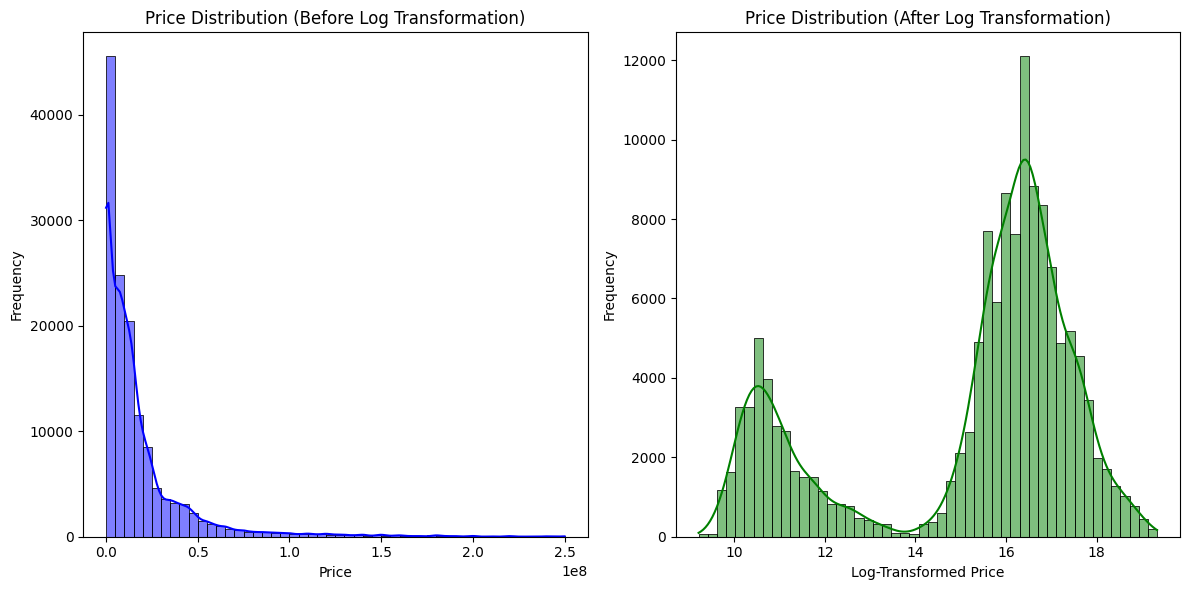

Skewness of Original Price: 3.49
Skewness of Log-Transformed Price: -0.93


In [6]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['price'], kde=True, bins=50, color='blue')
plt.title('Price Distribution (Before Log Transformation)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
sns.histplot(df['price_log'], kde=True, bins=50, color='green')
plt.title('Price Distribution (After Log Transformation)')
plt.xlabel('Log-Transformed Price')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

price_skewness = skew(df['price'].dropna())
price_log_skewness = skew(df['price_log'].dropna())
print(f"Skewness of Original Price: {price_skewness:.2f}")
print(f"Skewness of Log-Transformed Price: {price_log_skewness:.2f}")

## **Aggregate Features Addition**
**Note**: Training on separate frames would be ideal to remove price-diff overfit instead of normalize

In [7]:
df = df.drop(['page_url'], axis=1) # Ease RAM as high cardinality OHE
df_sale = df[ df['purpose'] == 'For Sale' ].copy()
df_rent = df[ df['purpose'] == 'For Rent' ].copy()
print(f"For Sale: {len(df_sale):,}")
print(f"For Rent: {len(df_rent):,}")

For Sale: 103,949
For Rent: 33,726


In [ ]:
# df['area_category'] = pd.cut(
#     df['area_sqft'],
#     bins=[0, 900, 1800, 3600, 6300, np.inf], # 1 gaz = 9sqft OR can do q=5
#     labels=['Studio/Small', 'Medium', 'Large', 'Very Large', 'Luxury']
# )
# df['room_density'] = ( df['bedrooms'] + df['baths'] ) / df['area_sqft']
# df['bed_bath_ratio'] = df['bedrooms'] / ( df['baths'] + 1 ) # As more attach-baths can have more prize.


In [ ]:
# #splitting dataset
# X = df.drop(['price','price_log'], axis=1)
# y = df['price_log']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
#                                     random_state=42, stratify=df['purpose']) # balance sale/rent


Train size: 77961
Test size: 25988


In [ ]:
# # num_features = X.select_dtypes(include=['number']).columns
# # Model was simply learning this formula: price = price_per_sqft * area_sqft giving 0.99 for Forest Ones.

# num_features = X.select_dtypes(include=['number']).columns
# num_features
# cat_features = X.select_dtypes(include=['object']).columns.drop(['page_url', 'location'])
# cat_features

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import datetime

def train_price_model(df_subset, purpose_name, tune_hyperparameters=True):
    print(f"Model Train for: {purpose_name.upper()}")
    X = df_subset.drop(['price', 'price_log', 'purpose'], axis=1)
    y = df_subset['price_log']

    print(f"\nOriginal features: {list(X.columns)}")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42
    )
    print(f"\nTrain size: {len(X_train):,} samples")
    print(f"Test size: {len(X_test):,} samples")

    def add_features(X_df, is_train=True, train_stats=None):
        X = X_df.copy()
        # Room based features
        X['room_density'] = ( X['bedrooms'] + X['baths'] ) / X['area_sqft']
        X['bed_bath_ratio'] = X['bedrooms'] / ( X['baths'] + 1 )

        # Temporal features ( No need as we have only 18-19 dataset ) BUT is included in model.pkl
        # X['listing_age'] = datetime.datetime.now().year - X['year_added']
        # X['is_recent_list'] = (X['listing_age'] <= 2).astype(int)

        # Categorical binning ( NOW need to use q=5 as need to be in train-bounds )
        if is_train:
            area_bins = [0, X['area_sqft'].quantile(0.20), X['area_sqft'].quantile(0.40),
                        X['area_sqft'].quantile(0.60), X['area_sqft'].quantile(0.80), np.inf]
            bedroom_bins = [0, 2, 3, 5, np.inf]
            train_stats = {
                'area_bins': area_bins,
                'bedroom_bins': bedroom_bins
            }

        X['area_category'] = pd.cut(
            X['area_sqft'],
            bins=train_stats['area_bins'],
            labels=['Small', 'Medium', 'Large', 'VeryLarge', 'Luxury'],
            include_lowest=True
        )

        X['bedroom_category'] = pd.cut(
            X['bedrooms'],
            bins=train_stats['bedroom_bins'],
            labels=['1-2BR', '3BR', '4-5BR', '6+BR'],
            include_lowest=True
        )

        return X, train_stats

    print("\nDoing Agg-Features Eng: \n")
    X_train_fe, train_stats = add_features(X_train, is_train=True)
    X_test_fe, _ = add_features(X_test, is_train=False, train_stats=train_stats)

    print(f"New features: {set(X_train_fe.columns) - set(X_train.columns)}")
    cols_to_drop = ['year_added']
    X_train_fe = X_train_fe.drop(cols_to_drop, axis=1, errors='ignore')
    X_test_fe = X_test_fe.drop(cols_to_drop, axis=1, errors='ignore')

    # Identify feature types
    num_features = X_train_fe.select_dtypes(include=['number']).columns.tolist()
    cat_features = X_train_fe.select_dtypes(include=['object', 'category']).columns.tolist()
    print(f"\nNum features:{num_features}")
    print(f"Categorical features: {cat_features}")

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', RobustScaler(), num_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
        ],
        remainder='drop'
    )

    # Create the full pipeline with preprocessor and regressor( trying different regressors)
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        "Gradient Boosting": GradientBoostingRegressor(random_state=42),
        "XGBoost": XGBRegressor(random_state=42, n_estimators=200, learning_rate=0.1),
        "LightGBM": LGBMRegressor(random_state=42, n_estimators=200, learning_rate=0.1, n_jobs=-1),
        "CatBoost": CatBoostRegressor(verbose=0, random_state=42, iterations=300, learning_rate=0.1),
        # "SVR": SVR(kernel='rbf', C=100, epsilon=0.1),
        "KNN": KNeighborsRegressor(n_neighbors=5, n_jobs=-1)
    }

    results = {}
    best_r2 = 0.0
    best_pipeline = None
    best_model_name = None
    print("\nEvaluating Model: \n")

    for name, model in models.items():
        pipeline = Pipeline( [ ('preprocessor', preprocessor), ('regressor', model) ])
        pipeline.fit(X_train_fe, y_train)
        y_pred_log = pipeline.predict(X_test_fe)
        r2_log = r2_score(y_test, y_pred_log)

        # Metrics on original scale (more interpretable)
        y_test_org = np.expm1(y_test)
        y_pred_org = np.expm1(y_pred_log)
        rmse = np.sqrt( mean_squared_error(y_test_org, y_pred_org ) )
        mape = np.mean( np.abs( ( y_test_org - y_pred_org ) / y_test_org ) ) * 100

        # Cross-validation
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(pipeline, X_train_fe, y_train, cv=cv, scoring='r2', n_jobs=-1)

        results[name] = {
            'r2': r2_log,
            'rmse': rmse,
            'mape': mape,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std()
        }
        print(f"{name}: R² = {r2_log}, RMSE = {rmse:,.0f} PKR,  MAPE = {mape:.2f}%")
        print(f"CV R²:     {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

        if r2_log > best_r2:
            best_r2 = r2_log
            best_pipeline = pipeline
            best_model_name = name
    print(f"\nBest Model: {best_model_name} with R² = {best_r2}")

    if tune_hyperparameters and best_model_name in ['XGBoost', 'LightGBM', 'Random Forest', 'CatBoost']:
        print(f"\nHyperparameter tuning for {best_model_name}...")

        param_grids = {
            "LightGBM": {
                  'regressor__num_leaves': [31, 50, 100, 150],
                  'regressor__learning_rate': [0.01, 0.05, 0.1],
                  'regressor__n_estimators': [300, 500, 800],
                  'regressor__max_depth': [-1, 10, 20, 30],
                  'regressor__subsample': [0.7, 0.8, 0.9, 1.0],
                  'regressor__colsample_bytree': [0.7, 0.8, 0.9, 1.0],  # Old 'feature_fraction'
            },
            "XGBoost": {
                  'regressor__learning_rate': [0.01, 0.05, 0.1],
                  'regressor__n_estimators': [100, 200, 300],
                  'regressor__max_depth': [3, 5, 7],
                  'regressor__subsample': [0.7, 0.8, 0.9],
                  'regressor__colsample_bytree': [0.7, 0.8, 0.9],
            },
            "Random Forest": {
                  'regressor__n_estimators': [100, 200, 300],
                  'regressor__max_depth': [10, 20, 30],
                  'regressor__min_samples_split': [2, 5, 10],
                  'regressor__min_samples_leaf': [1, 2, 4],
                  'regressor__bootstrap': [True, False]
            },
            "CatBoost": {
                'regressor__learning_rate': uniform(0.01, 0.15),
                'regressor__iterations': randint(200, 500),
                'regressor__depth': randint(4, 10),
                'regressor__l2_leaf_reg': uniform(1, 10)
            }
        }

        random_search = RandomizedSearchCV(
            estimator=best_pipeline,
            param_distributions=param_grids[best_model_name],
            n_iter=50,
            scoring='r2',
            cv=3,
            n_jobs=-1,
            verbose=1,
            random_state=42
        )

        random_search.fit(X_train_fe, y_train)

        print(f"\nBest Parameters: {random_search.best_params_}")
        print(f"Best R² Score: {random_search.best_score_:.4f}")
        best_pipeline = random_search.best_estimator_

        # Re-evaluate
        y_pred_log = best_pipeline.predict(X_test_fe)
        y_test_org = np.expm1(y_test)
        y_pred_org = np.expm1(y_pred_log)
        final_r2 = r2_score(y_test, y_pred_log)
        final_rmse = np.sqrt(mean_squared_error(y_test_org, y_pred_org))
        final_mape = np.mean(np.abs((y_test_org - y_pred_org) / y_test_org)) * 100

        print(f"\nTuned Model Performance:")
        print(f"R² = {final_r2}, RMSE = {final_rmse:,.0f} PKR,  MAPE = {final_mape:.2f}%")
        results[best_model_name] = {
            'r2': final_r2,
            'rmse': final_rmse,
            'mape': final_mape,
            'cv_mean': random_search.best_score_,
            'cv_std': random_search.cv_results_['std_test_score'].mean()
        }


    y_pred_best = best_pipeline.predict(X_test_fe)
    y_test_org = np.expm1(y_test)
    y_pred_org = np.expm1(y_pred_best)

    # Actual vs Predicted + Residuals
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Scatter plot
    axes[0].scatter(y_test_org/1e6, y_pred_org/1e6, alpha=0.4, s=10)
    axes[0].plot([y_test_org.min()/1e6, y_test_org.max()/1e6],
                 [y_test_org.min()/1e6, y_test_org.max()/1e6], 'r--', lw=2)
    axes[0].set_xlabel('Actual Price (Millions PKR)', fontsize=12)
    axes[0].set_ylabel('Predicted Price (Millions PKR)', fontsize=12)
    axes[0].set_title(f'{purpose_name} - Actual vs Predicted ({best_model_name})', fontsize=14)
    axes[0].grid(alpha=0.3)

    # Residuals
    residuals = y_test_org - y_pred_org
    axes[1].scatter(y_pred_org/1e6, residuals/1e6, alpha=0.4, s=10)
    axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1].set_xlabel('Predicted Price (Millions PKR)', fontsize=12)
    axes[1].set_ylabel('Residual (Millions PKR)', fontsize=12)
    axes[1].set_title(f'{purpose_name} - Residual Plot', fontsize=14)
    axes[1].grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Residual distribution
    plt.figure(figsize=(10, 6))
    plt.hist(residuals/1e6, bins=50, edgecolor='black', alpha=0.7)
    plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
    plt.xlabel('Prediction Error (Millions PKR)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'{purpose_name} - Residual Distribution', fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    if hasattr(best_pipeline['regressor'], 'feature_importances_'):
        cat_features_encoded = list(best_pipeline['preprocessor']
                                    .named_transformers_['cat']
                                    .get_feature_names_out(cat_features))
        all_feature_names = num_features + cat_features_encoded

        importances = best_pipeline['regressor'].feature_importances_
        feature_imp = pd.DataFrame({
            'feature': all_feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False).head(6)

        plt.figure(figsize=(10, 8))
        plt.barh(feature_imp['feature'], feature_imp['importance'])
        plt.xlabel('Importance', fontsize=12)
        plt.title(f'{purpose_name} - Top 6 Feature Importances ({best_model_name})', fontsize=14)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

    return {
        'pipeline': best_pipeline,
        'model_name': best_model_name,
        'train_stats': train_stats,
        'results': results,
        'num_features': num_features,
        'cat_features': cat_features,
        'preprocessor': preprocessor
    }

Now do one-by-one for both splits.

Model Train for: FOR SALE

Original features: ['property_type', 'city', 'province_name', 'baths', 'bedrooms', 'area_sqft', 'year_added']

Train size: 77,961 samples
Test size: 25,988 samples

Doing Agg-Features Eng: 

New features: {'listing_age', 'room_density', 'area_category', 'bedroom_category', 'bed_bath_ratio', 'is_recent_list'}

Num features:['baths', 'bedrooms', 'area_sqft', 'room_density', 'bed_bath_ratio', 'listing_age', 'is_recent_list']
Categorical features: ['property_type', 'city', 'province_name', 'area_category', 'bedroom_category']

Evaluating Model: 

Linear Regression: R² = 0.7664515990295978, RMSE = 15,932,864 PKR,  MAPE = 43.03%
CV R²:     0.7593 ± 0.0231
Random Forest: R² = 0.8390070665022726, RMSE = 12,050,181 PKR,  MAPE = 34.04%
CV R²:     0.8378 ± 0.0016
Gradient Boosting: R² = 0.8104552992569881, RMSE = 13,119,456 PKR,  MAPE = 38.11%
CV R²:     0.8139 ± 0.0025
XGBoost: R² = 0.8386910798092937, RMSE = 12,142,671 PKR,  MAPE = 33.63%
CV R²:     0.8409 ± 0.0024
[L

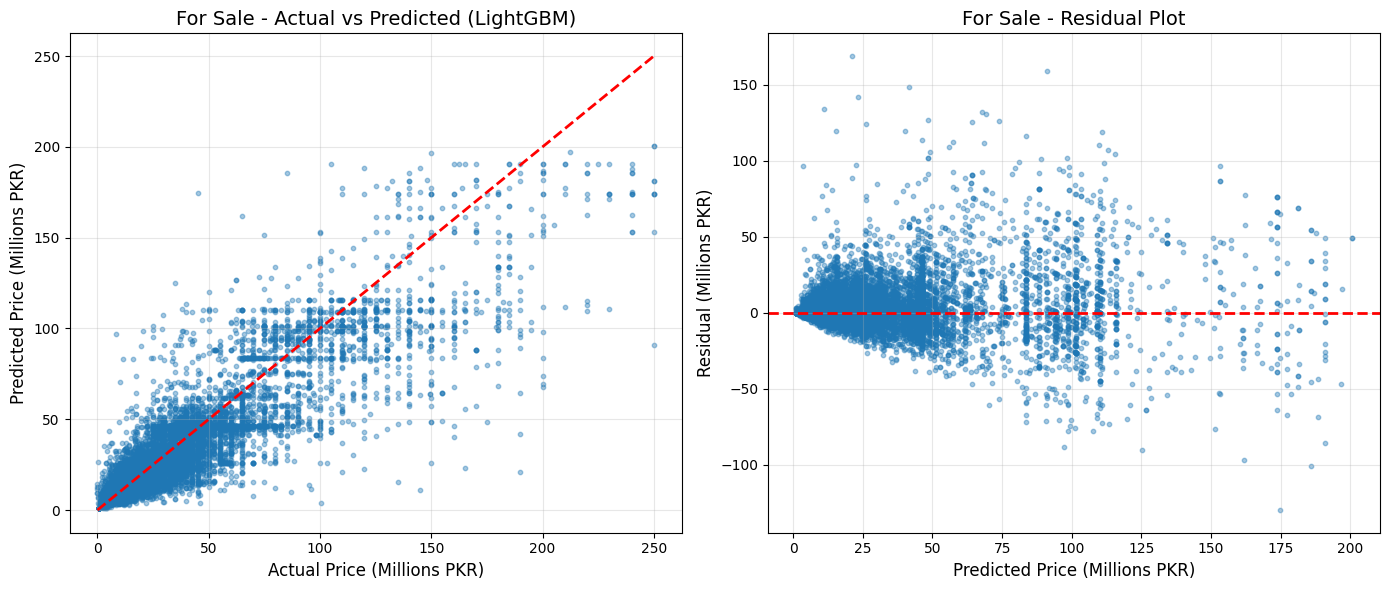

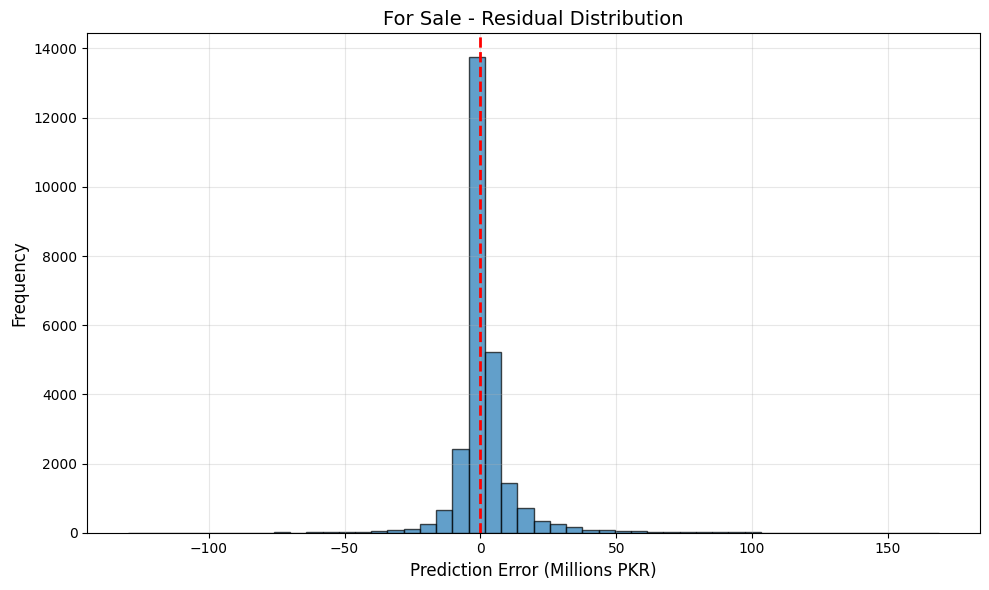

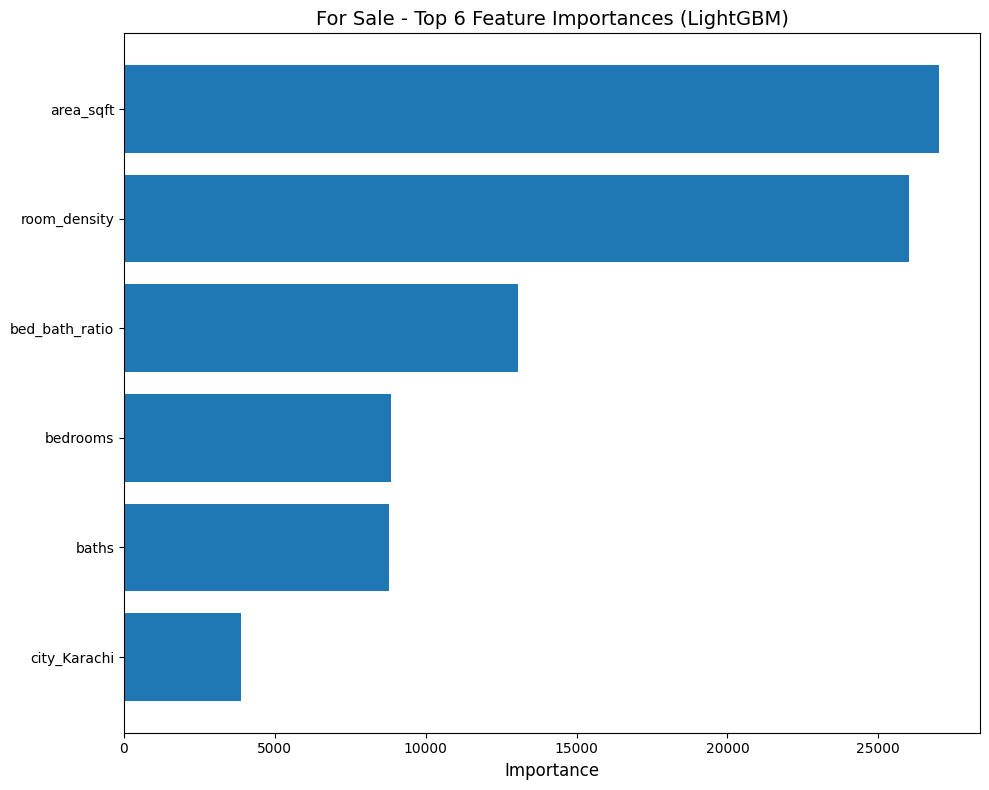

In [9]:
sale_artifacts = train_price_model(df_sale, 'For Sale', tune_hyperparameters=True)

Model Train for: FOR RENT

Original features: ['property_type', 'city', 'province_name', 'baths', 'bedrooms', 'area_sqft', 'year_added']

Train size: 25,294 samples
Test size: 8,432 samples

Doing Agg-Features Eng: 

New features: {'listing_age', 'room_density', 'area_category', 'bedroom_category', 'bed_bath_ratio', 'is_recent_list'}

Num features:['baths', 'bedrooms', 'area_sqft', 'room_density', 'bed_bath_ratio', 'listing_age', 'is_recent_list']
Categorical features: ['property_type', 'city', 'province_name', 'area_category', 'bedroom_category']

Evaluating Model: 

Linear Regression: R² = 0.7847819848131397, RMSE = 96,081 PKR,  MAPE = 30.44%
CV R²:     0.7884 ± 0.0085
Random Forest: R² = 0.8433750511757669, RMSE = 88,168 PKR,  MAPE = 24.52%
CV R²:     0.8410 ± 0.0042
Gradient Boosting: R² = 0.8185087718848957, RMSE = 91,962 PKR,  MAPE = 27.64%
CV R²:     0.8218 ± 0.0052
XGBoost: R² = 0.8464659298089086, RMSE = 88,968 PKR,  MAPE = 24.68%
CV R²:     0.8463 ± 0.0043
[LightGBM] [Info] A

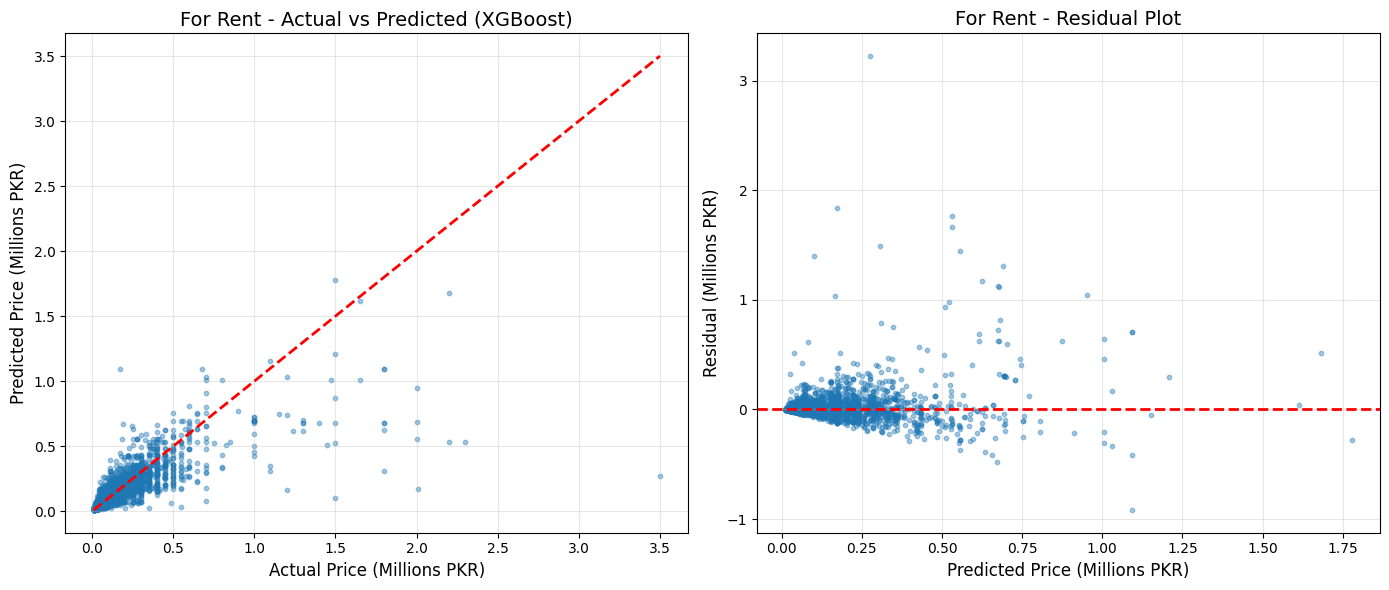

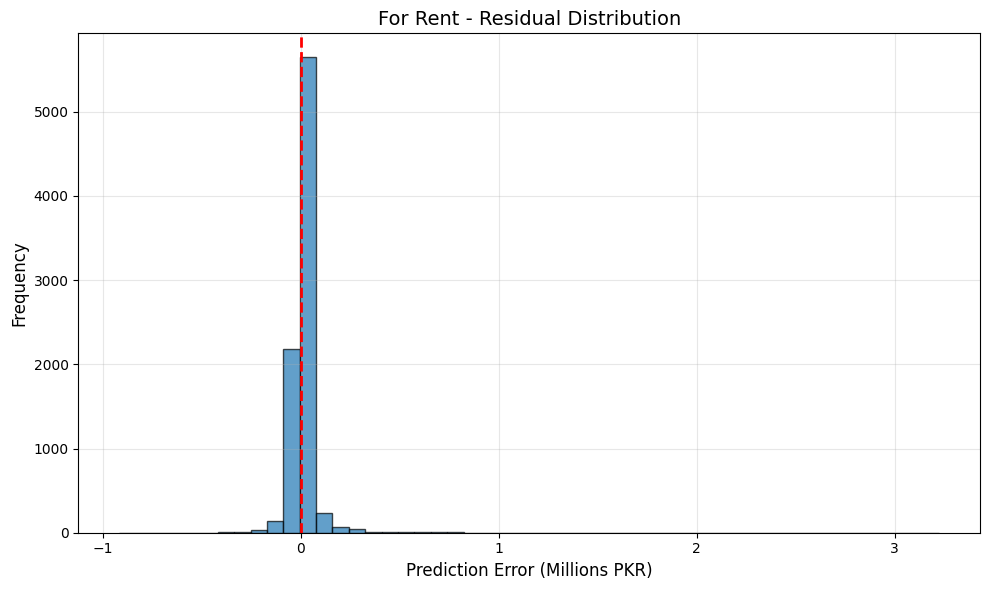

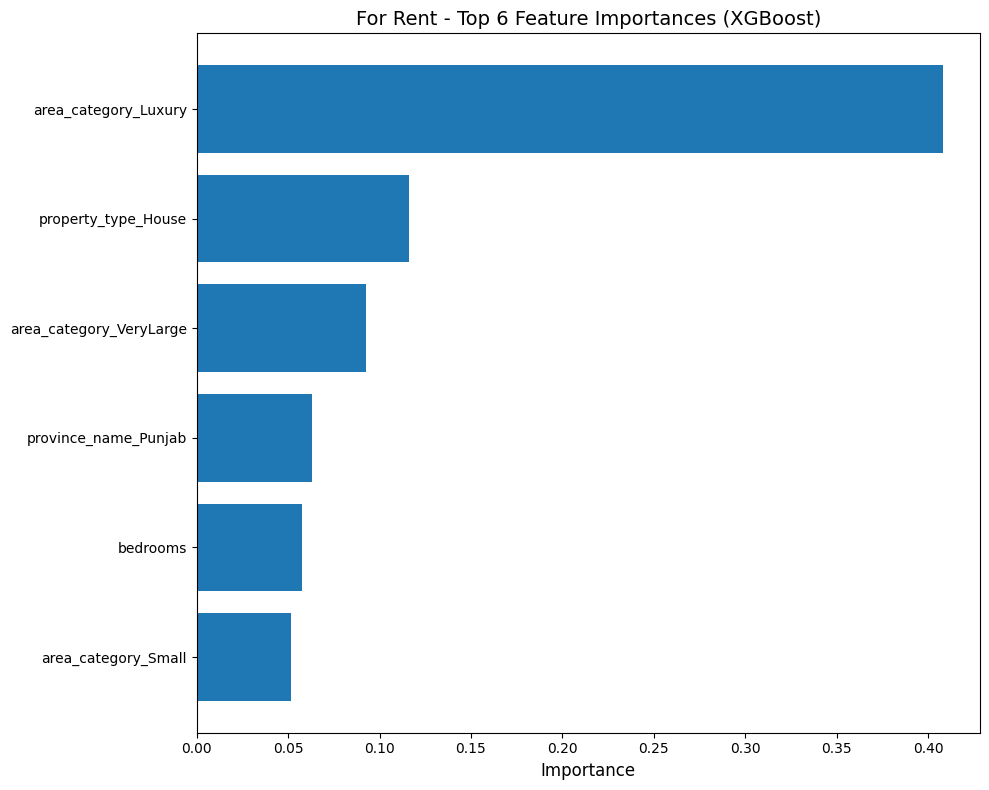

In [11]:
rent_artifacts = train_price_model(df_rent, 'For Rent', tune_hyperparameters=True)

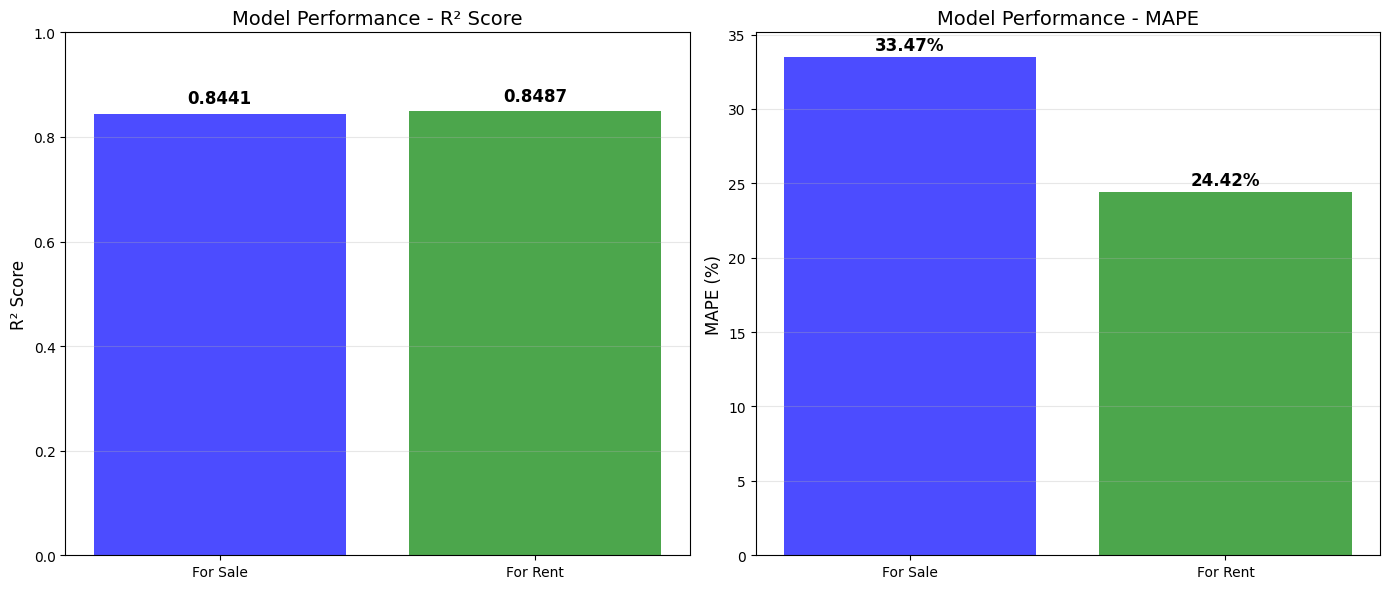

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# R² comparison
models = ['For Sale', 'For Rent']
r2_scores = [
    sale_artifacts['results'][sale_artifacts['model_name']]['r2'],
    rent_artifacts['results'][rent_artifacts['model_name']]['r2']
]
axes[0].bar(models, r2_scores, color=['blue', 'green'], alpha=0.7)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('Model Performance - R² Score', fontsize=14)
axes[0].set_ylim([0, 1])
axes[0].grid(alpha=0.3, axis='y')
for i, v in enumerate(r2_scores):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=12, fontweight='bold')

# MAPE comparison
mape_scores = [
    sale_artifacts['results'][sale_artifacts['model_name']]['mape'],
    rent_artifacts['results'][rent_artifacts['model_name']]['mape']
]
axes[1].bar(models, mape_scores, color=['blue', 'green'], alpha=0.7)
axes[1].set_ylabel('MAPE (%)', fontsize=12)
axes[1].set_title('Model Performance - MAPE', fontsize=14)
axes[1].grid(alpha=0.3, axis='y')
for i, v in enumerate(mape_scores):
    axes[1].text(i, v + 0.5, f'{v:.2f}%', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [15]:
print("Hi")

Hi


In [ ]:
import sys
joblib.dump(sale_artifacts['pipeline'], 'model_sale.pkl')
joblib.dump(rent_artifacts['pipeline'], 'model_rent.pkl')

# joblib.dump(sale_artifacts['train_stats'], 'train_stats_sale.pkl')
# joblib.dump(rent_artifacts['train_stats'], 'train_stats_rent.pkl')

# feature_info = {
#     'sale': {
#         'num_features': sale_artifacts['num_features'],
#         'cat_features': sale_artifacts['cat_features']
#     },
#     'rent': {
#         'num_features': rent_artifacts['num_features'],
#         'cat_features': rent_artifacts['cat_features']
#     }
# }
# joblib.dump(feature_info, 'feature_info.pkl')

if 'google.colab' in sys.modules:
    from google.colab import files
    files.download('model_sale.pkl')
    files.download('model_rent.pkl')
    # files.download('train_stats_sale.pkl')
    # files.download('train_stats_rent.pkl')
    # files.download('feature_info.pkl')